# `pyGIMLi(emg3d)`

Requires
- `pygimli>=1.5.2`
- `emg3d@inv-pygimli` (`pip install git+https://github.com/emsig/emg3d@inv-pygimli`

Super simple plus all possible inv-crimes (same mesh, some solver, ...).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import emg3d
import emg3d.inversion.pygimli as ipygimli

%run ../data/sampledata

In [2]:
%matplotlib widget

## Load Simulation (incl. Survey, Models, Data)

In [3]:
sim, model = load_data("../data/Block-1src-130rec-1freq")
model_init = sim.model.copy()

# sim.tol_gradient = 1e-2  # could be reduced further to potentially speed-up more

Data loaded from «/home/dtr/Codes/devInv/data/Block-1src-130rec-1freq.h5»
[emg3d v1.8.4.dev11+g36578d6 (format 1.0) on 2024-09-02T15:22:01.835714].


## Define regions, instantiate Kernel and Inversion

In [4]:
# Create region markers
markers = np.zeros(sim.model.shape, dtype=int)
markers[model.property_x < 0.1] = 1            # Only target is free

# Instantiate the emg3d-kernel for pyGIMLi
fop = ipygimli.Kernel(simulation=sim, markers=markers, pgthreads=1)

# Instantiate the inversion and set some inversion parameters
INV = ipygimli.Inversion(fop=fop)
#INV.inv.setCGLSTolerance(1)  # is _absolute_, not _relative_
INV.inv.setMaxCGLSIter(10)

# Set the regions.
INV.fop.setRegionProperties(1, limits=(0.0001, 2), startModel=1)                  # Target
INV.fop.setRegionProperties(0, background=True)                                   # Background

## Run inversion

In [5]:
INV.run(
    #maxIter=2, # just to test
    lam=100,  # btw 1-100
    lambdaFactor=0.9,
    stopAtChi1=False,
    #dPhi=5.0,
    #verbose=True,
    #debug=True,
    #startModel=model.property_x.ravel('F'),
    #isReference=True,
)

10/09/24 - 16:58:09 - pyGIMLi - INFO - :: pyGIMLi(emg3d) START ::
10/09/24 - 16:58:09 - pyGIMLi - INFO - Created startmodel from region infos: 6 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
10/09/24 - 16:58:13 - pyGIMLi - INFO - ===========================================================================
                                        it   F(m)         χ²          λ         ϕᵈ         ϕᵐ   ϕ=ϕᵈ+λϕᵐ   Δϕ (%)
                                       ---------------------------------------------------------------------------
10/09/24 - 16:58:13 - pyGIMLi - INFO -   0      1       17.4      100.0     4524.1        0.0     4524.1     0.00
10/09/24 - 16:59:07 - pyGIMLi - INFO -   1     20        0.4      100.0      103.8        0.0      106.3    97.65
10/09/24 - 17:00:03 - pyGIMLi - INFO -   2     24        0.3       90.0       66.0        0.0       66.0    37.92
10/09/24 - 17:01:05 - pyGIMLi - INFO -   3     25        0.3       81.0       65.0        0.0       65.0     1.45
10/09/24 - 17:02:07 - py

# Plots

Depth slice: -750.0 m


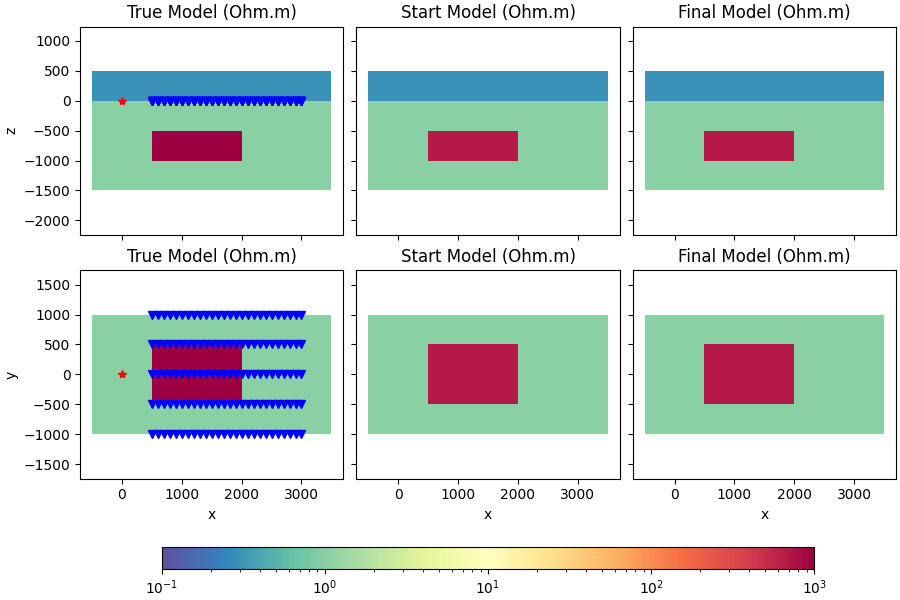

In [6]:
plot_models(sim, sim.model, model)

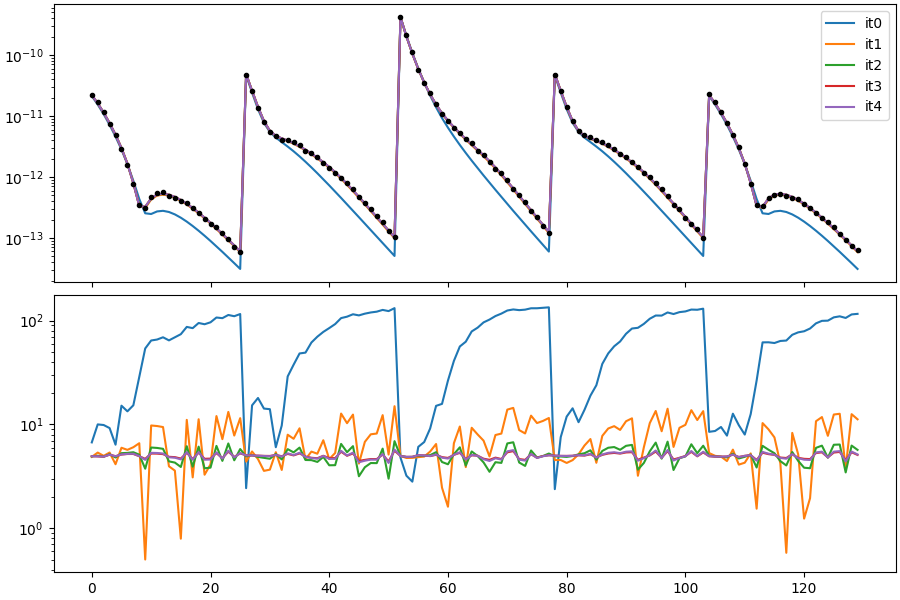

In [7]:
plot_responses(sim)

In [8]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Tue Sep 10 17:02:08 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC
  12.3.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.59.1
             emg3d : 1.8.4.dev6+gd2f88de
           empymod : 2.3.1
            xarray : 2024.6.0
        discretize : 0.10.0
              h5py : 3.11.0
        matplotlib : 3.9.1
              tqdm : 4.66.4
           IPython : 8.26.0
           pygimli : 1.5.2
            pgcore : 1.5.0
--------------------------------------------------------------------------------